In [7]:
%load_ext autoreload
%autoreload 2

import torch
from heterogeneity_gym import rectangle
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Create structures and images from uniform latent dimensions.**

In [8]:
n_images_to_create = 3
noise_std = 0.5

rectangle_model = rectangle.RectangleModel(noise_std=noise_std)
raw_images, structures, latent_samples = rectangle_model.sample_images(300)
clean_images, structures = rectangle_model.render_images_from_latent(latent_samples, noise_std=0)

latent_model = rectangle.Latent2DGaussianMixture()
# snr = torch.var(clean_images) / noise_std**2
# print("Observed Signal to noise ratio:", snr.item())
print(raw_images.shape)

torch.Size([300, 128, 128])


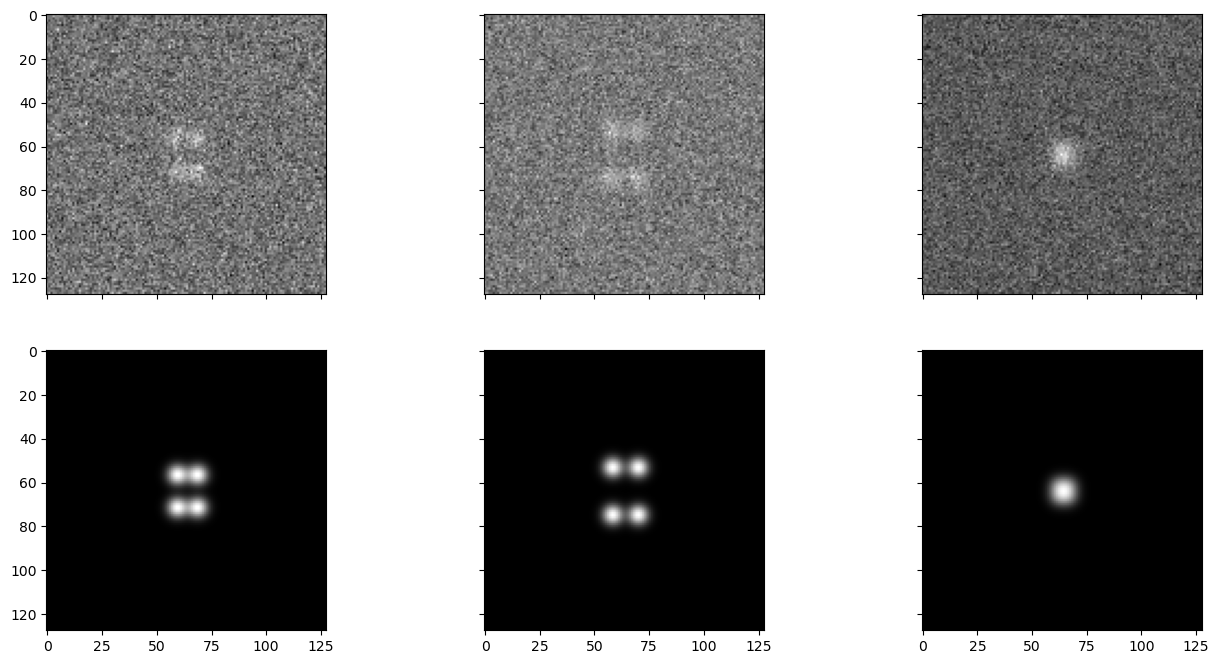

In [9]:
fig, axes = plt.subplots(2, n_images_to_create, sharex=True, sharey=True, figsize=(16, 8))

for i, ax in enumerate(axes[0]):
    ax.imshow(raw_images[i], cmap='gray')
for i, ax in enumerate(axes[1]):
    ax.imshow(clean_images[i], cmap='gray')

In [10]:
# Calculate log likelihoods
log_Pij = rectangle_model.evaluate_log_pij_matrix(raw_images, clean_images, noise_std)
print(log_Pij / 128**2)

tensor([[-0.5037, -0.5039, -0.5401,  ..., -0.5303, -0.5158, -0.5180],
        [-0.5123, -0.4947, -0.5571,  ..., -0.5155, -0.5186, -0.5151],
        [-0.5401, -0.5471, -0.5079,  ..., -0.5628, -0.5489, -0.5591],
        ...,
        [-0.5271, -0.5051, -0.5616,  ..., -0.5056, -0.5225, -0.5342],
        [-0.5152, -0.5094, -0.5519,  ..., -0.5238, -0.5050, -0.5335],
        [-0.5225, -0.5134, -0.5675,  ..., -0.5437, -0.5435, -0.4968]])


**Create images from a Gaussian mixture latent dimension model.**

Text(0, 0.5, 'Width')

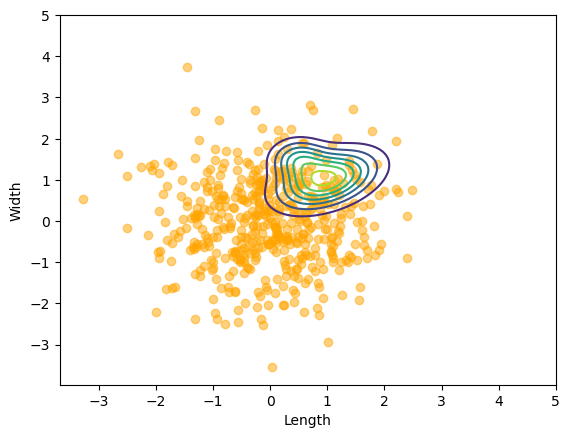

In [11]:

# Plot latent densities along with samples
mesh_size = 100
lengths = torch.linspace(-1, 5, mesh_size)
widths = torch.linspace(-1, 5, mesh_size)
l_grid, w_grid = torch.meshgrid(lengths, widths)

# Compute probability density
lw_grid = torch.cat((l_grid.reshape(-1, 1), w_grid.reshape(-1, 1)), dim=1)
probabilities = torch.tensor([rectangle_model.latent_density.evaluate_density(length_width) for length_width in lw_grid]).reshape(mesh_size, mesh_size)

# Generate samples from mixture model
num_samples = 500
lw_samples = latent_model.sample(num_samples)

plt.contour(l_grid.numpy(), w_grid.numpy(), probabilities.numpy())
plt.scatter(lw_samples[:, 0], lw_samples[:, 1], color='orange', alpha=0.5)
plt.xlabel("Length"); plt.ylabel("Width")

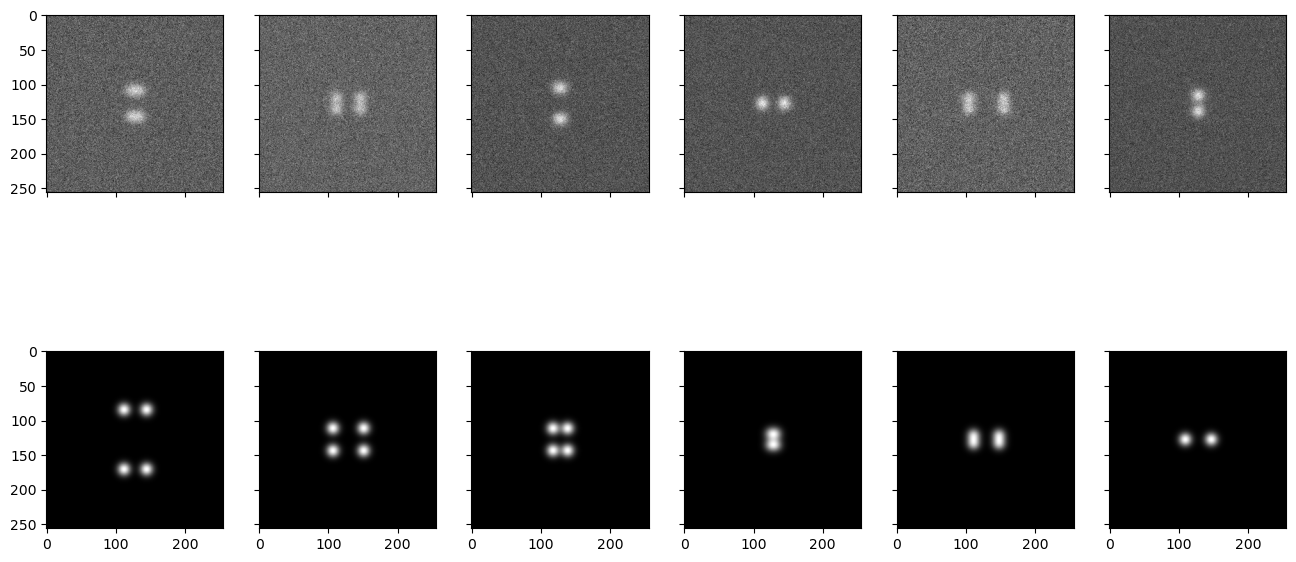

In [12]:
# Initialize rectangle models with and without noise.
noise_std = 0.25
image_width = 256
rectangle_model_with_noise = rectangle.RectangleModel(latent_density=latent_model, image_width_in_pixels=image_width, noise_std=noise_std)
rectangle_model_without_noise = rectangle.RectangleModel(latent_density=latent_model, image_width_in_pixels=image_width)

# Sample images from above models.
num_structures = 6
images_with_noise, structures, latents = rectangle_model_with_noise.sample_images(num_structures)
images_without_noise, structures, latents = rectangle_model_without_noise.sample_images(num_structures)

# Plot noisy and noiseless images from same latent distribution of lengths and widths.
fig, axes = plt.subplots(nrows=2, ncols=num_structures, sharex=True, sharey=True, figsize=(16, 8))

for i, ax in enumerate(axes[0]):
    ax.imshow(images_with_noise[i], cmap='gray')
for i, ax in enumerate(axes[1]):
    ax.imshow(images_without_noise[i], cmap='gray')